# Gaussian Process Regression

For the definition of Mueller-Brown potential, see https://www.wolframcloud.com/objects/demonstrations/TrajectoriesOnTheMullerBrownPotentialEnergySurface-source.nb.

$v(x,y) = \sum_{k=0}^3 A_k \mathrm{exp}\left[ a_k (x - x_k^0)^2 + b_k (x - x_k^0) (y - y_k^0) + c_k (y - y_k^0)^2 \right] $

**Generate Traning Data**

In [1]:
from math import exp, pow, tanh
import numpy as np
import matplotlib.pyplot as plt

def mueller_brown_potential(x, y):
  A = [-200, -100, -170, 15]
  a = [-1, -1, -6.5, 0.7]
  b = [0, 0, 11, 0.6]
  c = [-10, -10, -6.5, 0.7]
  x0 = [1, 0, -0.5, -1.0]
  y0 = [0, 0.5, 1.5, 1]
  value = 0
  for k in range(0, 4):
    value += 0.1 * A[k] * exp( a[k] * pow(x-x0[k], 2.0) + b[k] * (x-x0[k]) * (y-y0[k]) + c[k] * pow(y-y0[k], 2.0))
  return value

#main function
xx = np.arange(-1.8, 1.4, 0.1)
yy = np.arange(-0.4, 2.4, 0.1)
X, Y = np.meshgrid(xx, yy)
xy, xy_truncated = [],[]
z, z_truncated = [], []
for y in yy:
  for x in xx:
    v = mueller_brown_potential(x,y)
    z.append(v)
    xy.append([x,y])
    if v < 10:  #keep only low-energy points for ML training
      xy_truncated.append([x, y])
      z_truncated.append(v)
Z = np.reshape(z,(len(yy),-1))
print("Zmin:", np.amin(Z), "Zmax:", np.amax(Z))
print("Size of (future) training set:", len(z_truncated))

Zmin: -14.599803525171698 Zmax: 1194.4772333054245
Size of (future) training set: 696


**3-d Projection Surface**

nan nan


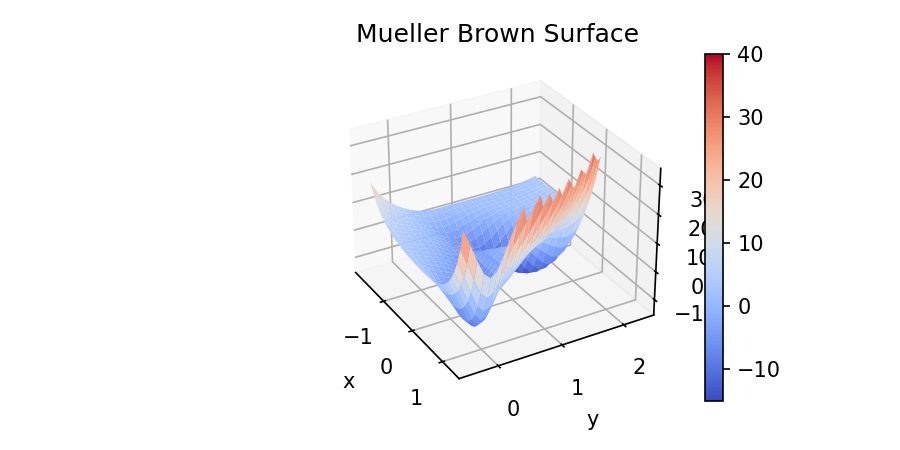

In [3]:
# %matplotlib widget
# from mpl_toolkits.mplot3d import Axes3D
# from google.colab import output
# output.enable_custom_widget_manager()
import copy

fig = plt.figure(figsize=(6,3), dpi=150)
ax = fig.add_subplot(projection='3d')

# Made copy of Z just to clean up the plot.
clean_Z = copy.copy(Z)
clean_Z[clean_Z>35] = np.nan
print(np.amax(clean_Z), np.amin(clean_Z))
surf=ax.plot_surface(X, Y, clean_Z, rstride=1, cstride=1,
                cmap=plt.cm.coolwarm, edgecolor='none', vmin=-15, vmax=40)

ax.view_init(30,-30)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title('Mueller Brown Surface')
plt.colorbar(surf)
plt.show()

**Contour surface**

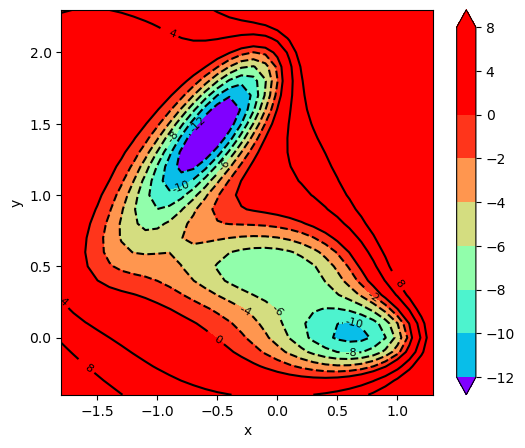

In [3]:
fig = plt.figure(figsize=(6,5), dpi=100) 
levels = [-12, -10, -8, -6, -4, -2, 0, 4, 8] 
ct = plt.contour(X, Y, Z, levels, colors='k') 
plt.clabel(ct, inline=True, fmt='%3.0f', fontsize=8) 
ct = plt.contourf(X, Y, Z, levels, cmap=plt.cm.rainbow, extend='both', vmin=-15, vmax=0) 
plt.xlabel("x") 
plt.ylabel("y") 
plt.colorbar() 
plt.show()

**Loading PyTorch, GpyTorch, and training data**

In [4]:
!pip install gpytorch

import numpy as np
import torch
import gpytorch
from torch import Tensor

#dataset = TensorDataset(Tensor(xy_truncated), Tensor(z_truncated))
#train_loader = DataLoader(dataset, batch_size=32)
#print("Size of training set:", len(train_loader.dataset))

Let us define the variables in our function as a vector of input features $\textbf{x}=[x,y]$ 

A set of $n$ configurations can be assembled in to a training set $\textbf{X}=[\textbf{x}_1, ...,\textbf{x}_n]$ with a set of observations $\textbf{y}=[y_1,...,y_n]$. For noisy samples, we can assume that an observations is seperate from the underlying function according to $y=f(\textbf{x})+\mathit{ε}$, where the noise, $\mathit{ε}$, follows a gaussian distribution $\mathit{ε}\sim\mathcal{N}(0,σ^2_n)$. The prior distribution of underlying functions follows a Gaussian distribution $\textbf{f}(\textbf{X})\sim\mathcal{N}(\textbf{0}, \textbf{K}(\textbf{X},\textbf{X}))$, where $\textbf{0}$ is the mean function and $\textbf{K}$ is the covaraince kernel matrix. The covariance kernel matrix is assembled based on a kernel function, $k$, that is used to compare the simularities between input vectors:

$\textbf{K(X,X)}=
\begin{bmatrix}
k(\textbf{x}_1,\textbf{x}_1) & \ldots & k(\textbf{x}_1,\textbf{x}_n)\\
\vdots & \ddots & \vdots\\
k(\textbf{x}_n,\textbf{x}_1) & \ldots & k(\textbf{x}_n,\textbf{x}_n)\\
\end{bmatrix}$

Here we used the radial basis function:

$\mathrm{k}(\textbf{x}_a,\textbf{x}_b)=\sigma^2_f\mathrm{exp}(-\frac{||\textbf{x}_a-\textbf{x}_b||^2}{2l^2})$

In [5]:
# Setup GPR Model: Taken directly From gpytorch tutorial with minor changes 
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        #super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        super().__init__(train_x, train_y, likelihood)
        #self.mean_module = gpytorch.means.ConstantMean()
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

X_gpr = Tensor(xy_truncated)
Y_gpr = Tensor(z_truncated)

# Initialize Likelihood and Model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(X_gpr, Y_gpr, likelihood)

Let $\textbf{K}=\textbf{K}(\textbf{X},\textbf{X})+σ^2_n\textbf{I}$

Hyperparameters $\Theta = \{σ^2_f, l, \sigma^2_n\}$ are optimized by maximizing the marginal likelihood log: 

$\mathrm{log}\:p(\textbf{y}|\textbf{X},\textbf{Θ})=-\frac{1}{2}\textbf{y}^\mathrm{T}\textbf{K}^{-1}\textbf{y}-\frac{1}{2}\mathrm{log}\:|\textbf{K}|-\frac{n}{2}\mathrm{log}\:2\pi$

To demonstrate that the negative marginal likelihood log function is smooth, the noise hyperparameter, $\sigma^2_n$ is fixed, while a grid search is performed over the lengthscale, $l$, and output/scale variance, $σ^2_f$

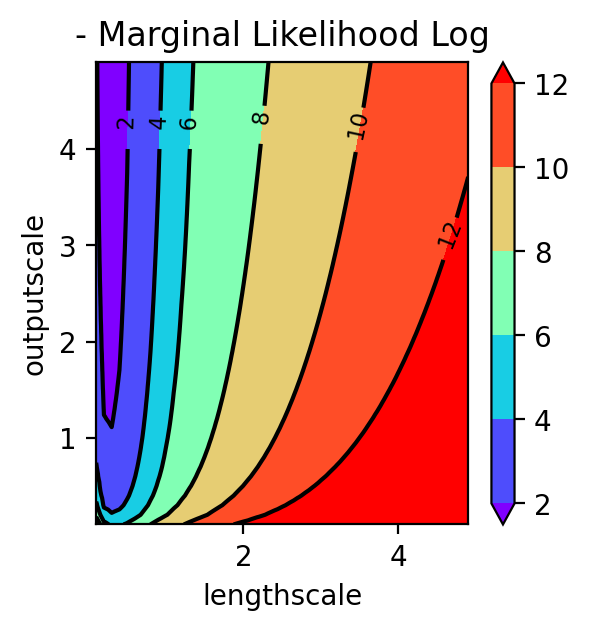

In [6]:
noise_value = 1.0
scale_and_length = [[i*.1,j*.1] for i in range(1,50) for j in range(1,50)]

x_plt = []
y_plt = []
z_plt = []

for pair in scale_and_length:
    hypers = {
        'likelihood.noise_covar.noise': torch.tensor(noise_value),
        'covar_module.base_kernel.lengthscale': torch.tensor(pair[0]),
        'covar_module.outputscale': torch.tensor(pair[1]),
    }
    model.initialize(**hypers)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
    output = model(X_gpr)
    loss = -mll(output, Y_gpr)
    x_plt.append(pair[0])
    y_plt.append(pair[1])
    z_plt.append(loss.item())

fig = plt.figure(figsize=(3,3), dpi=200)

plt.subplot(1, 1, 1)
ct = plt.tricontour(x_plt, y_plt, z_plt, colors='k')
plt.clabel(ct, inline=True, fmt='%3.0f', fontsize=8)
ct = plt.tricontourf(x_plt, y_plt, z_plt, cmap=plt.cm.rainbow, extend='both')
plt.title("- Marginal Likelihood Log")
plt.xlabel("lengthscale")
plt.ylabel("outputscale")
plt.colorbar()

plt.show()

In [7]:
model.train()
likelihood.train()

def train_model(model, likelihood, print_hp=False):
  hypers = {
      'likelihood.noise_covar.noise': torch.tensor(1.0),
      'covar_module.base_kernel.lengthscale': torch.tensor(1.0),
      'covar_module.outputscale': torch.tensor(1.0),
  }
  model.initialize(**hypers)
  if print_hp:
      # Print untrained hyperparameters
      for param_name, param in model.named_parameters():
        print(f'Parameter name: {param_name:42} value = {param.item()}')

  training_iter = 100
  # Find optimal model hyperparameters
  # Use the adam optimizer
  #optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

  # Use the SGD optimizer 
  optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

  # "Loss" for GPs - the marginal log likelihood
  mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

  for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(X_gpr)
    # Calc loss and backprop gradients
    loss = -mll(output, Y_gpr)
    loss.backward()
    if print_hp:
      print('Iter %d/%d - Loss: %.3f scale: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.outputscale.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()
      ))
      optimizer.step()
  if print_hp:
    # Print Trained hyperparameters
    for param_name, param in model.named_parameters():
      print(f'Parameter name: {param_name:42} value = {param.item()}')

train_model(model, likelihood, print_hp=True)

Parameter name: likelihood.noise_covar.raw_noise           value = 0.5411666631698608
Parameter name: covar_module.raw_outputscale               value = 0.5413248538970947
Parameter name: covar_module.base_kernel.raw_lengthscale   value = 0.5413248538970947
Iter 1/100 - Loss: 5.879 scale: 1.000   lengthscale: 1.000   noise: 1.000
Iter 2/100 - Loss: 4.263 scale: 1.046   lengthscale: 0.787   noise: 1.136
Iter 3/100 - Loss: 3.360 scale: 1.087   lengthscale: 0.633   noise: 1.209
Iter 4/100 - Loss: 2.854 scale: 1.119   lengthscale: 0.536   noise: 1.250
Iter 5/100 - Loss: 2.479 scale: 1.149   lengthscale: 0.459   noise: 1.272
Iter 6/100 - Loss: 2.255 scale: 1.178   lengthscale: 0.405   noise: 1.279
Iter 7/100 - Loss: 2.135 scale: 1.204   lengthscale: 0.369   noise: 1.279
Iter 8/100 - Loss: 2.063 scale: 1.230   lengthscale: 0.345   noise: 1.275
Iter 9/100 - Loss: 2.014 scale: 1.254   lengthscale: 0.327   noise: 1.268
Iter 10/100 - Loss: 1.980 scale: 1.279   lengthscale: 0.313   noise: 1.260
I

The optimized model can be used to make predictions on new input space, $\textbf{x}_*$. Predictions will follow a gaussian distribution $\mathcal{N}\sim(μ_*,\textbf{Σ}_*)$, where $μ^*=\textbf{K}^\mathrm{T}_\ast\textbf{K}^{-1}\textbf{y}$ and $\textbf{Σ}_*=\textbf{K}_{**}-\textbf{K}^\mathrm{T}_*\textbf{K}^{-1}\textbf{K}_*$. In the above equaiton, $\textbf{K}_*=\textbf{K}(\textbf{X},\textbf{x}_*)$ and $\textbf{K}_{**}=\textbf{K}(\textbf{x}_*,\textbf{x}_*)$



diff, min, max: -1194.476291681491 1.0934081629251118
var, min, max: 0.036013365 2.7670674


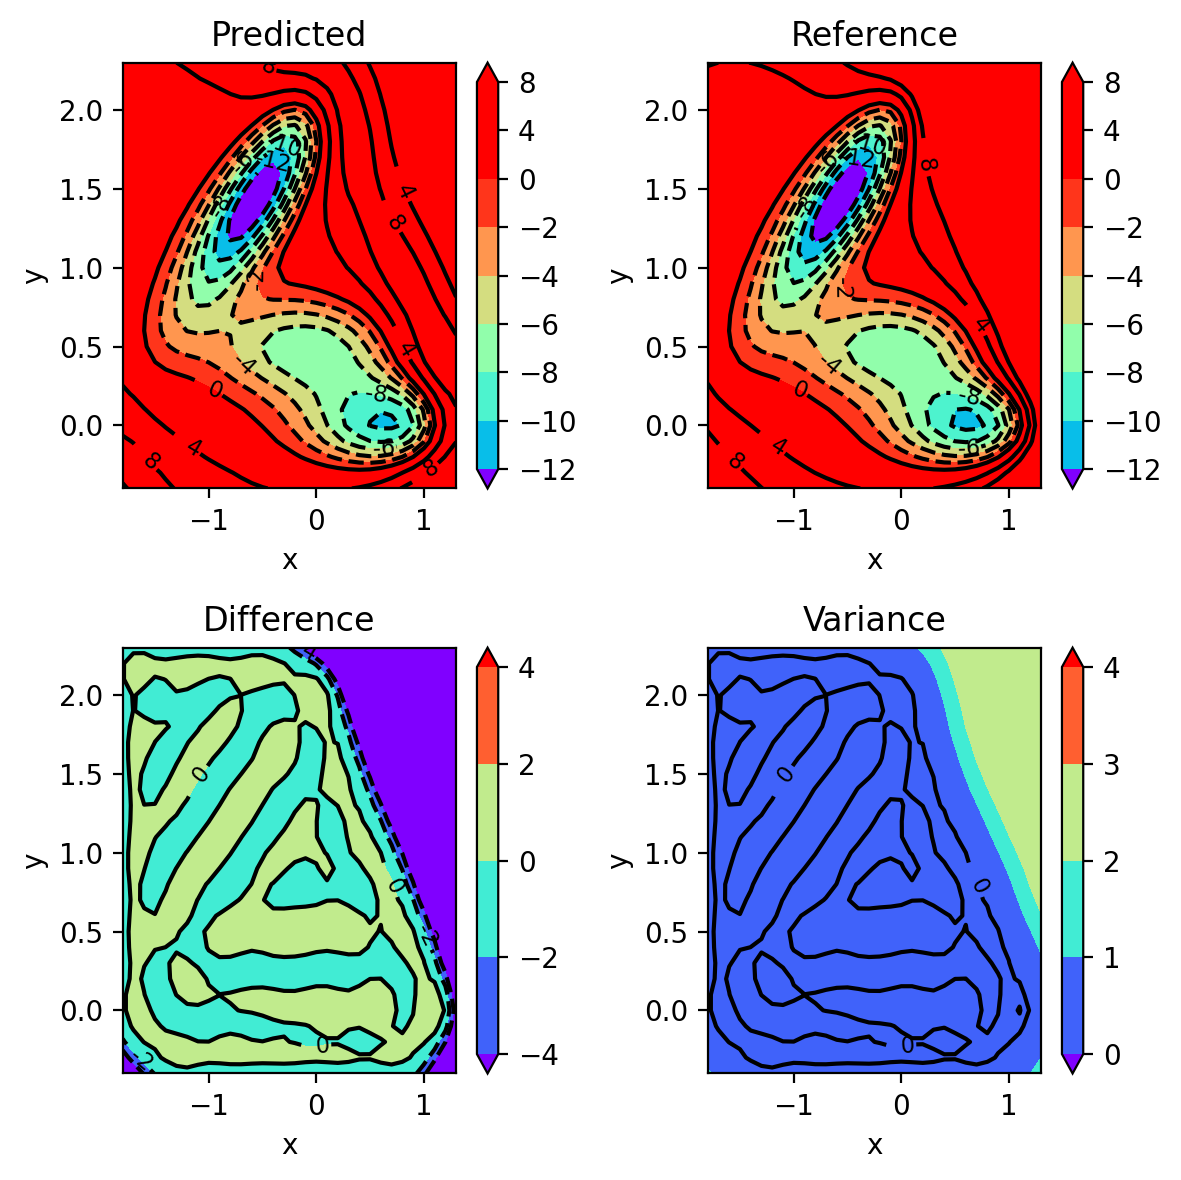

In [8]:
# Show the predicted surface, and compare to the reference one
def show_surface(model):
  model.eval()
  z_pred = model(Tensor(xy)).mean
  z_var = model(Tensor(xy)).variance
  Z_pred = np.reshape(z_pred.detach().numpy(),(len(yy),-1))
  Z_var = np.reshape(z_var.detach().numpy(),(len(yy),-1))
  Zdiff = np.subtract(Z_pred, Z)
  fig = plt.figure(figsize=(6,6), dpi=200)

  plt.subplot(2, 2, 1)
  levels = [-12, -10, -8, -6, -4, -2, 0, 4, 8]
  ct = plt.contour(X, Y, Z_pred, levels, colors='k')
  plt.clabel(ct, inline=True, fmt='%3.0f', fontsize=8)
  ct = plt.contourf(X, Y, Z_pred, levels, cmap=plt.cm.rainbow, extend='both', vmin=-15, vmax=0)
  plt.title("Predicted")
  plt.xlabel("x")
  plt.ylabel("y")
  plt.colorbar()

  plt.subplot(2, 2, 2)
  levels = [-12, -10, -8, -6, -4, -2, 0, 4, 8]
  ct = plt.contour(X, Y, Z, levels, colors='k')
  plt.clabel(ct, inline=True, fmt='%3.0f', fontsize=8)
  ct = plt.contourf(X, Y, Z, levels, cmap=plt.cm.rainbow, extend='both', vmin=-15, vmax=0)
  plt.title("Reference")
  plt.xlabel("x")
  plt.ylabel("y")
  plt.colorbar()

  plt.subplot(2, 2, 3)
  levels = [-4, -2, 0, 2, 4]
  ct = plt.contour(X, Y, Zdiff, levels, colors='k')
  plt.clabel(ct, inline=True, fmt='%3.0f', fontsize=8)
  ct = plt.contourf(X, Y, Zdiff, levels, cmap=plt.cm.rainbow, extend='both', vmin=-4, vmax=4)
  plt.title("Difference")
  plt.xlabel("x")
  plt.ylabel("y")
  print("diff, min, max:", np.amin(Zdiff), np.amax(Zdiff))
  plt.colorbar()

  plt.subplot(2, 2, 4)
  levels = [0, 1, 2, 3, 4]
  ct = plt.contour(X, Y, Zdiff, levels, colors='k')
  plt.clabel(ct, inline=True, fmt='%3.0f', fontsize=8)
  ct = plt.contourf(X, Y, Z_var, levels, cmap=plt.cm.rainbow, extend='both', vmin=0, vmax=4)
  plt.title("Variance")
  plt.xlabel("x")
  plt.ylabel("y")
  print("var, min, max:", np.amin(Z_var), np.amax(Z_var))
  plt.colorbar()

  plt.tight_layout()

  plt.show()

show_surface(model)

Model Performance and Training Set Size

In [9]:
print("Size of (current) training set:", Y_gpr.shape[0])
X_test = X_gpr.detach()
Y_test = Y_gpr.detach()
def evaluate_model(train_x, train_y, test_x, test_y, model):
  model.eval()
  preds_train = model(train_x).mean
  preds_test = model(test_x).mean
  print(train_y.shape, preds_train.shape)
  rmse_train = torch.sqrt(torch.mean(train_y - preds_train))
  rmse_test = torch.sqrt(torch.mean(test_y - preds_test))
  r2 = 1 - torch.sum((train_y-preds_train)**2)/torch.sum((train_y-torch.mean(train_y))**2)
  q2 = 1 - torch.sum((train_y-preds_train)**2)/torch.sum((train_y-torch.mean(train_y))**2)
  print("Training Data - RMSE: %.3f R^2: %3f" % (rmse_train, r2))
  print("Teseting Data - RMSE: %.3f R^2: %3f" % (rmse_test, q2))
  return rmse_train, r2, rmse_test, q2

def reduce_training_set(train_x, train_y, new_size):
  arr_index = np.arange(train_y.shape[0])
  np.random.shuffle(arr_index)
  return train_x[arr_index[:new_size],:], train_y[arr_index[:new_size]]

def new_model(train_x, train_y):
  likelihood = gpytorch.likelihoods.GaussianLikelihood()
  model = ExactGPModel(train_x, train_y, likelihood)
  model.train()
  likelihood.train()
  train_model(model, likelihood, print_hp=False)
  return model

size_list = []
rmse_train_list = []
r2_list = []
rmse_test_list = []
q2_list = []

training_set_sizes = [696, 600, 500, 400, 300, 200, 100]
for set_size in training_set_sizes:
  X_gpr, Y_gpr = reduce_training_set(X_gpr, Y_gpr, set_size)
  model = new_model(X_gpr, Y_gpr)
  rmse_train, r2, rmse_test, q2 = evaluate_model(X_gpr, Y_gpr, X_test, Y_test, model)
  size_list.append(set_size)
  rmse_train_list.append(rmse_train)
  r2_list.append(r2)
  rmse_test_list.append(rmse_test)
  q2_list.append(q2)

training_set_dict = {
    'Training Set Size': size_list,
    'Training Set RMSE': rmse_train_list,
    'R^2': r2_list,
    'Testing Set RMSE': rmse_test_list,
    'Q^2': q2_list
}

Size of (current) training set: 696


/opt/homebrew/Caskroom/mambaforge/base/lib/python3.10/site-packages/gpytorch/models/exact_gp.py:274: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


torch.Size([696]) torch.Size([696])
Training Data - RMSE: 0.214 R^2: 0.711877
Teseting Data - RMSE: 0.214 R^2: 0.711877
torch.Size([600]) torch.Size([600])
Training Data - RMSE: 0.227 R^2: 0.706675
Teseting Data - RMSE: 0.185 R^2: 0.706675
torch.Size([500]) torch.Size([500])
Training Data - RMSE: 0.243 R^2: 0.688276
Teseting Data - RMSE: 0.155 R^2: 0.688276
torch.Size([400]) torch.Size([400])
Training Data - RMSE: 0.259 R^2: 0.650607
Teseting Data - RMSE: 0.060 R^2: 0.650607
torch.Size([300]) torch.Size([300])
Training Data - RMSE: 0.268 R^2: 0.631616
Teseting Data - RMSE: 0.263 R^2: 0.631616
torch.Size([200]) torch.Size([200])
Training Data - RMSE: 0.283 R^2: 0.595591
Teseting Data - RMSE: 0.569 R^2: 0.595591
torch.Size([100]) torch.Size([100])
Training Data - RMSE: 0.317 R^2: 0.560439
Teseting Data - RMSE: 0.966 R^2: 0.560439


In [10]:
import tabulate
print(tabulate.tabulate(training_set_dict, headers = 'keys'))

ModuleNotFoundError: No module named 'tabulate'

Comaparing Kernels

In [ ]:
# Setup GPR Model: Taken directly From gpytorch tutorial with minor changes 
class GPModel_kernel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, kernel):
        #super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        #self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = kernel

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

X_gpr = Tensor(xy_truncated) 
Y_gpr = Tensor(z_truncated)

kernels = [
    gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel()),
    gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel()),
    gpytorch.kernels.ScaleKernel(gpytorch.kernels.RQKernel())    
]

def train_model_k(model, likelihood):
  training_iter = 50
  # Use the SGD optimizer 
  optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
  # "Loss" for GPs - the marginal log likelihood
  mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
  for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(X_gpr)
    # Calc loss and backprop gradients
    loss = -mll(output, Y_gpr)
    loss.backward()
    optimizer.step()

for kernel in kernels:
  # Initialize Likelihood and Model
  likelihood = gpytorch.likelihoods.GaussianLikelihood()
  model = GPModel_kernel(X_gpr, Y_gpr, likelihood, kernel)
  model.train()
  likelihood.train()
  train_model_k(model, likelihood)
  rmse_train, r2, rmse_test, q2 = evaluate_model(X_gpr, Y_gpr, X_test, Y_test, model)
  print(rmse_train)



